## Practical Data Science Final Project- 15688
### Yelp Restaurant Recommender System
##### By: Sri Siva Harish Kamma (srisivak), Aayush Bhardwaj (aayushb1), Khushboo Banwari (kbanwari)

### Introduction

Our primary objective is to develop a restaurant recommender system based on reviews posted by users on Yelp. This is used to determine the preferences of users and thus recommend new restaurants to them. We apply techniques learnt in Collaborative Filtering part of our lecture in class to predict how users would rate the restaurants they have not been to. 

There are a number of sources of information using which we can build the recommender system, for example, user-user, item-user and item-item. For this kind of a recommender system, we could use text of reviews, categories of restaurants a user has reviewed, location of the restaurants he has visited and rated to factor in his preferences. For this particular project, we will use 'user-restaurant' interactions of ratings of his previous visited restaurants. 

In our model, we aim to use this information to provide high quality recommendations to the user. There are a number of challenges that arise when a new restaurant is added or a new user signs up since this user does not have any previous instance of 'user-restaurant' interaction. Thus, we calculate similarity scores with existing users based on existing values of the user or item.

Using Yelp’s API we extract data of user-restaurant interactions from which we extract collaborative and content based features to identify customer and restaurant. We evaluate the performance of the models using the Root Mean Squared Error (RMSE) metric and compare the models’ performances. 

### Content

In this project, we will show how to create a restaurant recommender system using matrix factorization in Python.

We have extracted data for reviews of multiple restaurants in Pittsburgh from the Yelp API. 

We will cover the following topics in this project:
- [Importing the Libraries](#Importing-the-Libraries)
- [Data Extraction](#Data-Extraction)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Recommender System](#Recommender-System)
- [Results](#Results)
- [Conclusions Limitations and Further work](#Conclusions-Limitations-and-Further-work)

### Importing the Libraries 

In [116]:
import io, time, json
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import matplotlib
import math
from scipy.sparse.linalg import svds
matplotlib.use("svg")
%matplotlib inline
plt.style.use("ggplot")
import warnings
warnings.filterwarnings('ignore')

### Data Extraction

The following function returns the raw HTML content of the URL passed in as an argument. 

In [4]:
def retrieve_html(url):
    """
    Return the raw HTML at the specified URL.

    Args:
        url (string): url of the restaurant on Yelp

    Returns:
        status_code (integer): status code returned by the request
        raw_html (string): the raw HTML content of the response, properly encoded according to the HTTP headers.
    """
    
    response = requests.get(url)
    return (response.status_code, response.text)
    pass


The following function retrieves all the restaurants from Yelp given a query (location), using an API key. 

In [5]:
def all_restaurants(api_key, query):
    """
    Retrieve ALL the restaurants on Yelp for a given query.

    Args:
        query (string): Search term

    Returns:
        results (list): list of dicts representing each business
    """
    headers = {"Authorization": "bearer " + api_key}
    params = {"location": query, "categories": "restaurants", "limit": 20, "offset": 0}
    allRestaurantNameList = []
    allRestaurantURLList = []
    continueCallingYelpAPI = True
    while (continueCallingYelpAPI):
        response = requests.get("https://api.yelp.com/v3/businesses/search", headers=headers, params=params)
        
        myJson = (response.json())
        
        allRestaurantNameList.extend(list(myJson['businesses']))
        if(len(list(myJson['businesses'])) < 20):
            continueCallingYelpAPI = False
        else: 
            params["offset"] = params["offset"] + 20
            time.sleep(.200)
    return allRestaurantNameList
    pass


Here, we extract all restaurants in Knoxville, Pittsburgh. We have also extracted data for other locations like Oakland, Polish Hill and Shadyside. The data of Knoxville is shown here, the others are added onto the dataset as well. 

In [124]:
allRestaurantNameList = all_restaurants(key, 'Knoxville, Pittsburgh')
allRestaurantNameList[:5]

[{'alias': 'alla-famiglia-pittsburgh',
  'categories': [{'alias': 'italian', 'title': 'Italian'}],
  'coordinates': {'latitude': 40.42161, 'longitude': -79.99346},
  'display_phone': '(412) 488-1440',
  'distance': 978.4383300765214,
  'id': 'vNQkym5qZ-E-4AJ4IQ5JEg',
  'image_url': 'https://s3-media2.fl.yelpcdn.com/bphoto/6HtXOsbIxpm6dUxd2JnCJg/o.jpg',
  'is_closed': False,
  'location': {'address1': '804 E Warrington Ave',
   'address2': '',
   'address3': '',
   'city': 'Pittsburgh',
   'country': 'US',
   'display_address': ['804 E Warrington Ave', 'Pittsburgh, PA 15210'],
   'state': 'PA',
   'zip_code': '15210'},
  'name': 'Alla Famiglia',
  'phone': '+14124881440',
  'price': '$$$$',
  'rating': 4.5,
  'review_count': 177,
  'transactions': [],
  'url': 'https://www.yelp.com/biz/alla-famiglia-pittsburgh?adjust_creative=2iUepcQcEkBeAKNYB-HNAA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=2iUepcQcEkBeAKNYB-HNAA'},
 {'alias': 'fat-heads-saloon-pittsburgh',
  

First, we create a dataframe of restaurant names and their URLs

In [125]:
dfAllRes=pd.DataFrame(allRestaurantNameList)
dfAllRes1=pd.DataFrame(dfAllRes[['name','url']])
dfAllRes1.head()

,name,url
0,Alla Famiglia,https://www.yelp.com/biz/alla-famiglia-pittsbu...
1,Fat Heads Saloon,https://www.yelp.com/biz/fat-heads-saloon-pitt...
2,Onion Maiden,https://www.yelp.com/biz/onion-maiden-pittsbur...
3,Piper's Pub,https://www.yelp.com/biz/pipers-pub-pittsburgh...
4,Doce Taqueria,https://www.yelp.com/biz/doce-taqueria-pittsbu...


Extracting addresses of the restaurants for adding on to the dataframe.

In [127]:
def extract_address(location): 
    return location.get('address1')
pass
dfAllRes2=dfAllRes['location'].apply(extract_address)
dfAllRes2=pd.DataFrame(dfAllRes2)
dfAllRes2['neighborhood']='Knoxville'
dfAllRes2.head()

,location,neighborhood
0,804 E Warrington Ave,Knoxville
1,1805 E Carson St,Knoxville
2,639 E Warrington Ave,Knoxville
3,1828 E Carson St,Knoxville
4,1220 E Carson St,Knoxville


Extracting the categories of the restaurants and adding on to the dataframe.

In [128]:
def extract_categories(categories):
    allCategories=''
    for elem in categories:
        allCategories=allCategories+', '+elem.get('title') 
    allCategories=allCategories[2:]
    return allCategories
pass

dfAllRes3=dfAllRes['categories'].apply(extract_categories)
dfAllRes3=pd.DataFrame(dfAllRes3)
dfAllRes3.head()

,categories
0,Italian
1,American (Traditional)
2,"Vegan, Vegetarian, Asian Fusion"
3,"British, Irish, Pubs"
4,"Mexican, Food Trucks"


Concatenating the above dataframes to create our dataset.The resulting dataset has restaurant name, URL, location and category. 

In [129]:
dfAllRestaurants=pd.concat([dfAllRes1, dfAllRes2, dfAllRes3], axis=1)
dfAllRestaurants.head()

,name,url,location,neighborhood,categories
0,Alla Famiglia,https://www.yelp.com/biz/alla-famiglia-pittsbu...,804 E Warrington Ave,Knoxville,Italian
1,Fat Heads Saloon,https://www.yelp.com/biz/fat-heads-saloon-pitt...,1805 E Carson St,Knoxville,American (Traditional)
2,Onion Maiden,https://www.yelp.com/biz/onion-maiden-pittsbur...,639 E Warrington Ave,Knoxville,"Vegan, Vegetarian, Asian Fusion"
3,Piper's Pub,https://www.yelp.com/biz/pipers-pub-pittsburgh...,1828 E Carson St,Knoxville,"British, Irish, Pubs"
4,Doce Taqueria,https://www.yelp.com/biz/doce-taqueria-pittsbu...,1220 E Carson St,Knoxville,"Mexican, Food Trucks"


The following function returns a paginated list of reviews given the html corresponding to a Yelp restaurant. 





In [130]:
def parse_my_page(html):
    """
    Parse the reviews on a single page of a restaurant.
    
    Args:
        html (string): String of HTML corresponding to a Yelp restaurant

    Returns:
        tuple(list, string): a tuple of two elements
            first element: list of dictionaries corresponding to the extracted review information
            second element: URL for the next page of reviews (or None if it is the last page)
    """
    reviwList = []
    soup = BeautifulSoup(html, "html.parser")
   
    for link in soup.find_all('div', attrs={'class':'review review--with-sidebar'}):
        reviewDict = {}
        reviewDict["review_id"] = link.get('data-review-id')
        reviewDict["user_id"] = link.get('data-signup-object').rsplit(':', 1)[1]
        inside = link.find('div', attrs={'class':'review-content'})
        reviewDict["rating"] = float ((inside.find('div', attrs={'class':'i-stars'})).get('title')[:3]) 
        reviewDate = inside.find('span', attrs={'class':'rating-qualifier'}).string
        if reviewDate is not None:
            reviewDict["date"] = reviewDate.strip()
        reviewDict["text"] = inside.find('p', attrs={'lang':'en'}).text
        reviwList.append(reviewDict)
    
    footer = soup.find('div', attrs={'class':'pagination-block'})
    nextRef = footer.find('a', attrs={'class':'u-decoration-none next pagination-links_anchor'})
    
    if nextRef is not None:
        nextURL = nextRef.get('href')
    else:
        nextURL = None       
            
    return reviwList, nextURL
pass


The following function extracts ALL the reviews given a restaurant url.

In [131]:
def extract_reviews(url):
    """
    Retrieve ALL of the reviews for a single restaurant on Yelp.

    Parameters:
        url (string): Yelp URL corresponding to the restaurant of interest.

    Returns:
        reviews (list): list of dictionaries containing extracted review information
    """
    allReviews=[]
    if url is not None:
        status, pageHTML = retrieve_html(url)
        if status==200:
            currentPageReviews, nextURL = parse_my_page(pageHTML)
            if nextURL is not None:
                allReviews.extend(currentPageReviews)
                allReviews.extend(extract_reviews(nextURL))
            else:
                allReviews.extend(currentPageReviews)
    
    
    return allReviews
    pass

Here, we extract reviews for all restaurants and add to the final dataframe.

In [221]:
lstDF=[]
count=1
for idx,row in dfAllRestaurants.iterrows():
    a=extract_reviews(row['url'])
    
    df2=pd.DataFrame(a)
    df2['restaurant']=(row['name'])
    df2['location']=(row['location'])
    df2['categories']=(row['categories'])
    df2['url']=(row['url'])
    lstDF.append(df2)
        

knoxvilleRevDF = pd.concat(lstDF)
knoxvilleRevDF.to_csv('knoxvilledf.csv', index=False)


We now merge restaurants, users and reviews information to create our final dataset. (The code shown above is for the extraction of reviews of Knoxville restaurants. We executed the same code for the other locations and merged all the CSVs for the final dataset)

The final dataset contains review_id, user_id, text, restaurant, neighborhood, location, rating, categories, data and location

In [132]:
finalDF = pd.read_csv("finalDF.csv")

In [133]:
del finalDF['Unnamed: 0']

In [135]:
finalDF.head()

,categories,date,location,neighborhood,rating,restaurant,review_id,text,user_id
0,"Thai, Noodles",4/30/2018,242 S Highland Ave,Shadyside,5.0,Noodlehead,c9yLWQ394BEpvvIVeWZ5cQ,"The perfect place for incredibly good, incredi...",gfpQPBZGwn7KUedz6B9B2A
1,"Thai, Noodles",5/4/2018,242 S Highland Ave,Shadyside,4.0,Noodlehead,PTMCdI2LbEQv2jWf088b4g,Chang mai curry I'm a fan!Curry is soupier tha...,Lg-rKGTEsxNpnnNsR2tv-g
2,"Thai, Noodles",NaN,242 S Highland Ave,Shadyside,4.0,Noodlehead,WOPWtCTXiki7969sm_PUMQ,Great location and good food. Not too many opt...,tk8ztE5r3DBbpLdTDzVYXA
3,"Thai, Noodles",4/29/2018,242 S Highland Ave,Shadyside,5.0,Noodlehead,KTTCX_VW3v2JqQWQmZdrWg,I've heard so many great things about this pla...,pspJkQgUOap1OjTZVMbdsQ
4,"Thai, Noodles",4/18/2018,242 S Highland Ave,Shadyside,5.0,Noodlehead,s48_WzpKAdyi4NxshNrzWA,Craving Thai in downtown Pittsburgh? Noodlehea...,LX18SF9iQC06DBpS_TQFVA


### Exploratory Data Analysis

The number of reviews in the dataset.

In [140]:
len(finalDF.review_id)

77136

The number of user IDs (reviewers) in the dataset

In [137]:
len(finalDF.user_id.unique())

24152

The number of restaurants in the dataset.

In [138]:
len(finalDF.restaurant.unique())   

459

The number of reviews in every neighborhood.

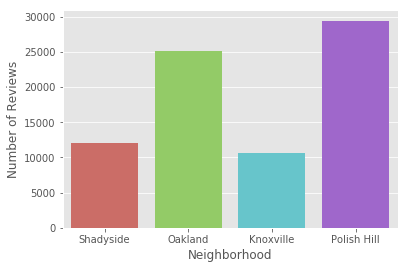

In [139]:
sns.countplot(x = 'neighborhood', data = finalDF, palette= 'hls').set(xlabel='Neighborhood', ylabel='Number of Reviews')
plt.show()
plt.savefig('count_plot')

Average rating of restaurants in every neighborhood.

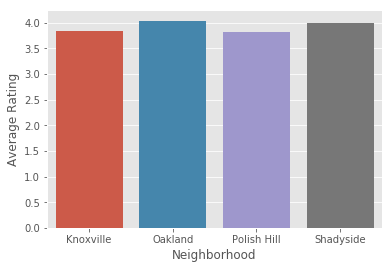

In [141]:
rating_neigh_df = finalDF.groupby(['neighborhood'])['rating'].mean().reset_index()

ax = sns.barplot(x = 'neighborhood', y = 'rating', 
              data = rating_neigh_df 
              )
ax.set(xlabel='Neighborhood', ylabel='Average Rating')
plt.show()


The number of users (reviewers) in every neighborhood

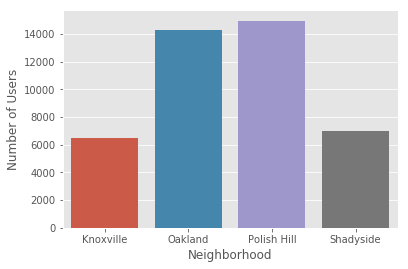

In [142]:
user_neigh_df = finalDF.groupby(['neighborhood'])['user_id'].nunique().reset_index()

ax = sns.barplot(x = 'neighborhood', y = 'user_id', 
              data = user_neigh_df 
              )
ax.set(xlabel='Neighborhood', ylabel='Number of Users')
plt.show()

The number of restaurants in every neighborhood

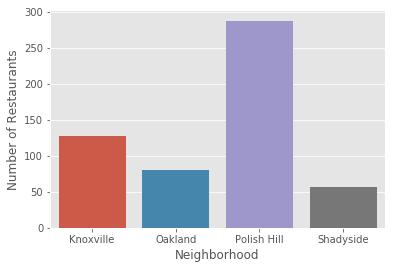

In [143]:
rest_neigh_df = finalDF.groupby(['neighborhood'])['restaurant'].nunique().reset_index()

ax = sns.barplot(x = 'neighborhood', y = 'restaurant', 
              data = rest_neigh_df 
              )
ax.set(xlabel='Neighborhood', ylabel='Number of Restaurants')
plt.show()

The number of reviews for every rating

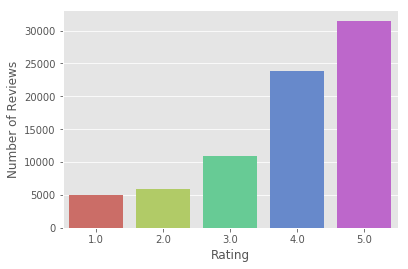

In [144]:
sns.countplot(x = 'rating', data = finalDF, palette= 'hls').set(xlabel='Rating', ylabel='Number of Reviews')
plt.show()
plt.savefig('count_plot')

### Recommender System

#### Collaborative Filtering

We use collaborative filtering to identify patterns of reviewers' preferences towards restaurants to have targeted recommendations. 

We create a dense matrix holding the ratings of users to restaurants and calculate a similarity score between the users and a similarity score between the restaurants. Imagine our data matrix as a 3D matrix of users as index, restaurants as columns and ratings as values i.e. X = $a_{ij}$ where i = 1,2,.....len(usernames) and j = 1,2,3,4....len(restaurants) and $a_{ij}$ denotes the rating given by user i for restaurant j

In collaborative filtering, we factorize our ratings matrix into two smaller feature matrices(U and V) whose product is equal to the original ratings matrix i.e. given a partially filled matrix (Since not every user reviews every restaurant) X, $X\in \mathbb{R}^{m\times n}$, we try to calculate the users feature matrix $U \in \mathbb{R}^{m\times k}$ and restaurants feature matrix $V \in \mathbb{R}^{n\times k}$ such that $UV^T = X$. This forms the basis of our hypothesis function for collaborative filtering: 

$$h_\theta(i,j) = u_i^T v_j$$

In general, $X$ contains 0's for ratings for users who haven't reviewed that restaurant (and usually quite sparse), which we have indicated with a presence 0. Let $S$ be the set of $(i,j)$ such that $X_{i,j} \neq 0$, so $S$ is the set of all pairs for which we have a rating. The cost function in this case is the Mean Squared error calculated using the formula below:

$$\ell(h_\theta(i,j),X_{i,j}) = (h_\theta(i,j) - X_{i,j})^2$$

The last ingredient to collaborative filtering is to impose an $l_2$ weight penalty on the parameters as we have discussed in class for recommendation systems, so our total loss is:

$$\sum_{i,j\in S}\ell(h_\theta(i,j),X_{i,j}) + \lambda_u ||U||_2^2 + \lambda_v ||V||_2^2$$ where $\lambda_u = \lambda_v = \lambda$.

#### Alternating Minimization for U and V feature matrix using Alternating Least Squares

Now we build the collaborative filtering recommender system using the method described above (alternating least squares). Essentially, we will alternate between optimizing over  U and  V by holding the other constant. By treating one matrix as a constant, we get exactly a weighted least squares problem, which has a well-known solution. 

#### Data Preprocessing for input Matrix creation

The below function creates the train and test matrix by splitting our data in the ratio of 90:10. The matrices have user id as rows, restaurants as columns and ratings as values as explained in the process for collaborative filtering.

In [12]:
def process(reviews, P):
    """ Given a dataframe of ratings and a random permutation, split the data into a training 
        and a testing set, in matrix form. 
        
        Args: 
            ratings (dataframe) : dataframe of ratings
            restaurants (dataframe) : dataframe of restaurants
            P (numpy 1D array) : random permutation vector
            
        Returns: 
            (X_tr, X_te, restaurant_names)  : training and testing splits of the ratings matrix (both 
                                         numpy 2D arrays), and a python list of restaurant names 
                                         corresponding to the columns of the ratings matrices. 
    """
    train_index = P[:math.floor(0.9*len(P))]
    test_index = P[math.floor(0.9*len(P)):]
        
    r = reviews.copy()
    
    r.loc[test_index, 'rating'] = 0    
    train = r.copy()
    
    q = reviews.copy()    
    q.loc[train_index, 'rating'] = 0
    
    test = q.copy()

    tr = train.pivot_table(index='user_id', columns='restaurant', values='rating')
    te = test.pivot_table(index='user_id', columns='restaurant', values='rating')
    
    rest_list = list(reviews.restaurant.unique())
      
    
    X_r = tr.fillna(0).as_matrix()
    X_e = te.fillna(0).as_matrix()
    
    return (X_r,X_e,rest_list)
    
    
    pass

X_tr, X_te, rest_list = process(finalDF, np.random.permutation(len(finalDF)))
print(X_tr, X_te, rest_list[:5])

[[ 0.   0.   5.  ...,  4.5  0.   0. ]
 [ 0.   0.   0.  ...,  0.   0.   0. ]
 [ 0.   0.   0.  ...,  0.   0.   0. ]
 ..., 
 [ 0.   0.   0.  ...,  0.   0.   0. ]
 [ 0.   0.   0.  ...,  0.   0.   0. ]
 [ 0.   0.   0.  ...,  0.   0.   0. ]] [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]] ['Noodlehead', "Millie's Homemade Ice Cream", 'Casbah', "Mercurio's", 'Spoon']


The below function trains the recommender system using ALS with cost function calculating MSE as per formula discussed above.

In [31]:
def error(X, U, V):
    """ Compute the mean error of the observed ratings in X and their estimated values. 
        Args: 
            X (numpy 2D array) : a ratings matrix as specified above
            U (numpy 2D array) : a matrix of features for each user
            V (numpy 2D array) : a matrix of features for each restaurant
        Returns: 
            (float) : the mean squared error of the observed ratings with their estimated values
        """
    w = np.zeros(X.shape)
    w[np.where(X!=0)]=1
    
    X_pred = U@(V.T)
    X_err = (X-X_pred)*w
    mse = np.mean(X_err**2)
    return mse
    pass

def train(X, X_te, k, U, V, niters=10, lam=10, verbose=False):
    """ Train a collaborative filtering model. 
        Args: 
            X (numpy 2D array) : the training ratings matrix as specified above
            X_te (numpy 2D array) : the testing ratings matrix as specified above
            k (int) : the number of features use in the CF model
            U (numpy 2D array) : an initial matrix of features for each user
            V (numpy 2D array) : an initial matrix of features for each restaurant
            niters (int) : number of iterations to run
            lam (float) : regularization parameter
            verbose (boolean) : verbosity flag for printing useful messages
            
        Returns:
            (U,V) : A pair of the resulting learned matrix factorization
    """
    m = U.shape[0]
    k = U.shape[1]
    n = V.shape[0]
    
   
    w = np.zeros(X.shape)
    w[np.where(X!=0)]=1
    
    train_error = {}
    test_error = {}
    
    for itern in range(niters):
        for i in range(m):
            vi = V[np.where(w[i]!=0)].T
            a = vi@vi.T + lam*np.identity(vi.shape[0])
            b = vi@X[i].T[np.where(w[i]!=0)]
            U[i] = np.linalg.solve(a,b)

        for j in range(n):
            ui = U[np.where(w.T[j]!=0)].T
            a = ui@ui.T + lam*np.identity(ui.shape[0])
            b = ui@X.T[j].T[np.where(w.T[j]!=0)]
            V[j] = np.linalg.solve(a,b)
       
        if(verbose):
            train_error[itern] = error(X,U[i],V[j])
            test_error[itern] = error(X_te,U[i],V[j])
   
    return (U,V,train_error,test_error, U@V.T)
    pass

Using alserror function and the graph below we try to perform cross validation to identify k at which minimum error occurs.

In [32]:
def alserror(X, Xhat):
    """ Compute the mean error of the observed ratings in X and their estimated values. 
        Args: 
            X (numpy 2D array) : a ratings matrix as specified above
            U (numpy 2D array) : a matrix of features for each user
            V (numpy 2D array) : a matrix of features for each restaurant
        Returns: 
            (float) : the mean squared error of the observed ratings with their estimated values
        """
    w = np.zeros(X.shape)
    w[np.where(X!=0)]=1
    

    X_err = (X-Xhat)*w
    mse = np.mean(X_err**2)
    return mse
    pass

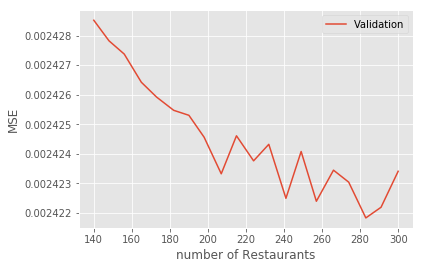

In [38]:
k = np.linspace(140,300,20, dtype = int)
errors_als_val = {}
errors_als_train = {}
for i in k:
    U = np.random.random((len(finalDF.user_id.unique()),i))
    V = np.random.random((len(finalDF.restaurant.unique()),i))
    errors_als_val[i] = alserror(X_te,train(X_tr, X_te, i, U, V,verbose=True)[4])

plt.plot(errors_als_val.keys(),errors_als_val.values(), label = 'Validation')
plt.xlabel('number of Restaurants')
plt.ylabel('MSE')
plt.legend()

From the graph of SVD, we see that the first minimum point occurs with MSE error = 0.0024235 at k = 206. In the below section we calculate the MSE using SVD in similar ways to find which one performs best for recommendation. 

#### Singular Value Decompostion

SVD is another popular matrix factorization technique that decomposes a m*n matrix into three matrices as below:

$$h_\theta(i,j) = u_is_iv_j^T$$



The matrix s is a diagonal matrix containing the singular values of the matrix X. There are exactly m singular values, where m is the rank of X. To compare restaurants, if most users who like one also like the other, we can simply keep the first k singular values in s, where k<m. This will give us the best rank-k approximation to X, and thus has effectively reduced the dimensionality of our original space. 

We proceed to calculate the U,S,V matrices for this method using the sparse.linalg svds library from scipy.sparse as can be seen from below methods

###### Cross Validation SVD
We try to identify the best k that gives the least possible MSE for our recommender system test case. Below two functions help in accomplishing the same.

In [25]:
def svd(k):
    u,s,v = svds(X_tr,k)
    s_diag = np.diag(s)
    Xhat = np.dot(np.dot(u,s_diag),v)
    return u,s_diag,v,Xhat

In [26]:
def svderror(X, Xhat):
    """ Compute the mean error of the observed ratings in X and their estimated values. 
        Args: 
            X (numpy 2D array) : a ratings matrix as specified above
            U (numpy 2D array) : a matrix of features for each user
            V (numpy 2D array) : a matrix of features for each restaurant
        Returns: 
            (float) : the mean squared error of the observed ratings with their estimated values
        """
    w = np.zeros(X.shape)
    w[np.where(X!=0)]=1
    
#     X_pred = U@S@(V.T)
    X_err = (X-Xhat)*w
    mse = np.mean(X_err**2)
    return mse
    pass


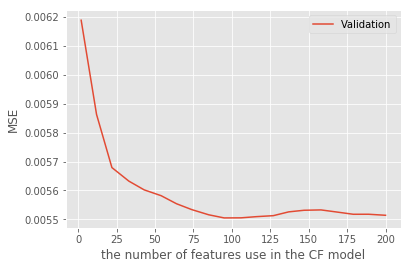

In [30]:
k = np.linspace(2,200,20, dtype = int)
errors_svd_val = {}
errors_svd_train = {}
for i in k:
    errors_svd_val[i] = svderror(X_te,svd(i)[3])
    errors_svd_train[i] = svderror(X_tr,svd(i)[3])

plt.plot(errors_svd_val.keys(),errors_svd_val.values(), label = 'Validation')
plt.xlabel('the number of features use in the CF model')
plt.ylabel('MSE')
plt.legend()

From above figure we see that minimum occurs at k=100 where MSE is approximately 0.0055 but the error is more than Alternating least squares hence we consider ALS to be our final model for the recommendation. 

 ### Results
 
As mentioned above, ALS performs slightly better than SVD at k=206 it has the lowest MSE, so now lets try to build the best restaurant recommendation list for each of our users using ALS below

In [40]:
U = np.random.random((len(finalDF.user_id.unique()),206))
V = np.random.random((len(finalDF.restaurant.unique()),206))
newU,newV = train(X_tr, X_te, 206, U, V,verbose=False)[0],train(X_tr, X_te, 206, U, V,verbose=False)[1]

In [41]:
def recommend(X, U, V, rest_list):
    """ Recommend a new restaurant for every user.
        Args: 
            X (numpy 2D array) : the training ratings matrix as specified above
            U (numpy 2D array) : a learned matrix of features for each user
            V (numpy 2D array) : a learned matrix of features for each restaurant
            rec_rest : a list of restaurant names corresponding to the columns of the ratings matrix
        Returns
            (list) : a list of restaurant names recommended for each user
    """
    
    rec_rest = []
    
    p = np.zeros(X.shape)    
    p[np.where(X==0)]=1
    
    x_pred = U@(V.T)*p       
    max_user = np.argmax(x_pred, axis=1)
    
    for i in max_user:
        rec_rest.append(rest_list[i])
    
    return rec_rest    
    pass
    
recommendations = recommend(X_te, newU, newV,rest_list)
print(recommendations[:10])

["Buford's Kitchen", 'Stagioni', 'Stagioni', 'Dinette', 'Stagioni', 'Stagioni', "Alexander's Italian Bistro", 'The Bistro At Courtyard by Marriott Shadyside', 'Sausalido', 'The Bistro At Courtyard by Marriott Shadyside']


The result above gives recommended restaurants for the users. The first restaurant corresponds to the first user, the second to the second user, and so on. 

#### Test Case 
Now, we pick a random user and look at his reviewed restaurants. We compare this to the recommended restaurants from our model.

In [214]:
random.seed(1)
unique_users = list(finalDF['user_id'].unique())
random_user_id = random.choice(unique_users)
rest_of_users = finalDF.loc[finalDF['user_id'] == random_user_id]
print(rest_of_users[['restaurant', 'rating', 'categories']].sort_values(by=['rating'], ascending=False))

                restaurant  rating                                  categories
40943    The Smiling Moose     5.0  Bars, Music Venues, American (Traditional)
42270  Mallorca Restaurant     5.0                Spanish, Seafood, Portuguese


In [215]:
rest_recommended = recommendations[unique_users.index(random_user_id)]
print ("Recommended Restaurant:", rest_recommended)
print("Categories:", finalDF.loc[finalDF['restaurant']== rest_recommended]['categories'].tolist()[0])

Recommended Restaurant: The Bistro At Courtyard by Marriott Shadyside
Categories: Bars, Cafes, Coffee & Tea


As can be seen above, the recommender system recommends the user on the basis of his/her top rated restaurants. In this case, the user rated 'The Smiling Moose' and 'Mallorca' restaurants high, and thus the recommender system recommended a similar category restaurant to the user- 'The Bistro At Courtyard by Marriott Shadyside'. 

### Conclusions Limitations and Further work

From our analysis and measures of accuracy,  it is clear that alternating least squares method which uses collaborative filtering does a very successful job to build a restaurant recommender system in this case. 

Further work:

1. Analysis of review text sentiments in calculating similarity scores can make the recommender system more comprehensive. This can be done using unsupervised learning algorithms like Gaussian Mixture Models. 
2. Better handling of missing data for restaurant names, reviews etc. will greatly help the user-item interaction scores there-by improving our model.
3. Restaurant-restaurant interactions can be worked on for recommender systems by studying the similarity between restaurants.
4. User-user interactions can be made by studying demographics of users, their interactions with other users (through social media analysis) to build a robust restaurant recommender system. 

Limitations:

Since we haven't worked on user-user interactions (due to lack of availability of data), this system will not do well when a new user comes in and there are no previous reviews to analyse. 

Further studies on the topic can be done using the following links:

https://www.coursera.org/specializations/recommender-systems

http://infolab.stanford.edu/~ullman/mmds/ch9.pdf

https://medium.com/recombee-blog/recommender-systems-explained-d98e8221f468

https://www.math.uci.edu/icamp/summer/research/student_research/recommender_systems_slides.pdf



### References
1. http://www.cs.carleton.edu/cs_comps/0607/recommend/recommender/svd.html
2. http://www.datasciencecourse.org/notes/recommender/
3. http://cs229.stanford.edu/proj2013/SawantPai-YelpFoodRecommendationSystem.pdf
4. https://en.wikipedia.org/wiki/Collaborative_filtering
